In [47]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")


In [61]:
DATA_PATH = "../dataset/processed/transactions_context.csv"

df = pd.read_csv(DATA_PATH)
df.head()


,order_id,user_id,products,order_dow,order_hour,is_weekend,time_bucket,context_label,days_since_prior_order
0,2539329,1,"[196, 14084, 12427, 26088, 26405]",2,8,0,morning,Weekday_Morning,NaN
1,2398795,1,"[196, 10258, 12427, 13176, 26088, 13032]",3,7,0,morning,Weekday_Morning,15.0
2,473747,1,"[196, 12427, 10258, 25133, 30450]",3,12,0,afternoon,Weekday_Afternoon,21.0
3,2254736,1,"[196, 12427, 10258, 25133, 26405]",4,7,0,morning,Weekday_Morning,29.0
4,431534,1,"[196, 12427, 10258, 25133, 10326, 17122, 41787...",4,15,0,afternoon,Weekday_Afternoon,28.0


In [49]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346083 entries, 0 to 3346082
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   products                object 
 3   order_dow               int64  
 4   order_hour              int64  
 5   is_weekend              int64  
 6   time_bucket             object 
 7   context_label           object 
 8   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 229.8+ MB


In [63]:
# products đang là string dạng list → convert về list
df["products"] = df["products"].apply(eval)

# số lượng sản phẩm mỗi đơn
df["num_products"] = df["products"].apply(len)

df[["order_id", "num_products", "context_label"]].head()


,order_id,num_products,context_label
0,2539329,5,Weekday_Morning
1,2398795,6,Weekday_Morning
2,473747,5,Weekday_Afternoon
3,2254736,5,Weekday_Morning
4,431534,8,Weekday_Afternoon


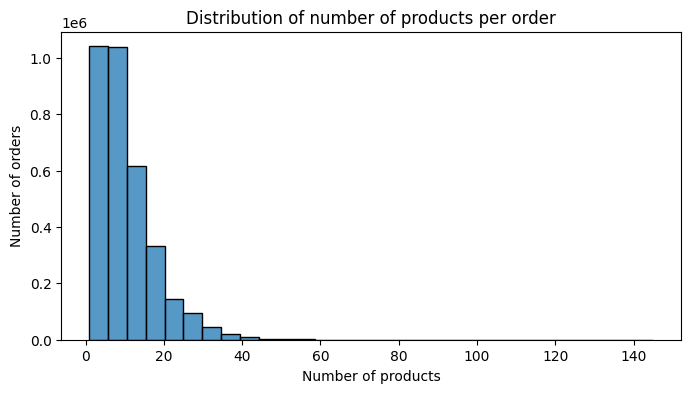

In [64]:
plt.figure(figsize=(8,4))
sns.histplot(df["num_products"], bins=30)
plt.title("Distribution of number of products per order")
plt.xlabel("Number of products")
plt.ylabel("Number of orders")
plt.show()


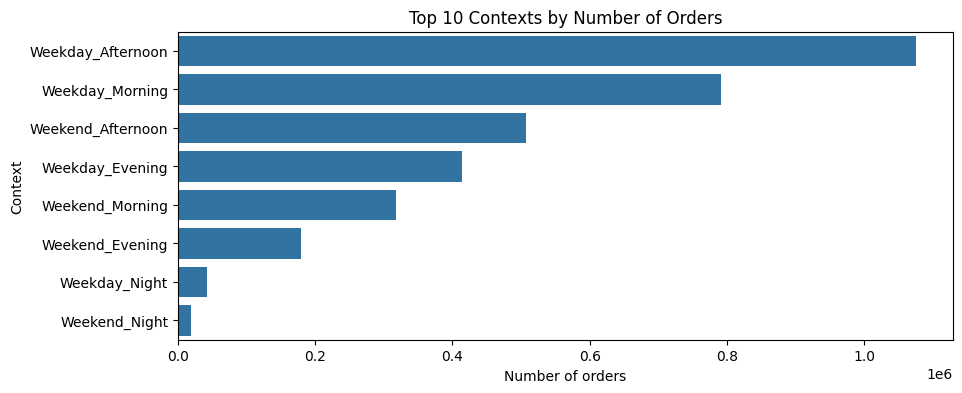

In [65]:
top_contexts = df["context_label"].value_counts().head(10)

plt.figure(figsize=(10,4))
sns.barplot(
    x=top_contexts.values,
    y=top_contexts.index
)
plt.title("Top 10 Contexts by Number of Orders")
plt.xlabel("Number of orders")
plt.ylabel("Context")
plt.show()


In [66]:
RULE_INDEX_PATH = "../checkpoints/association_rules/fpgrowth_context_rule_index.pkl"

rule_index = joblib.load(RULE_INDEX_PATH)

rule_index["_meta"]


{'schema_version': 2,
 'algorithm': 'fpgrowth',
 'algorithm_version': 2,
 'created_at': '2026-01-23T12:58:21.715197',
 'stats': {'contexts': 511, 'antecedents': 254630, 'rules': 668550}}

In [67]:
def extract_sample_rules(rule_index, max_contexts=5, max_rules_per_context=50):
    rows = []

    for i, (context, ctx_rules) in enumerate(rule_index["data"].items()):
        if i >= max_contexts:
            break

        for ant_key, rules in ctx_rules.items():
            for rule in rules[:max_rules_per_context]:
                rows.append({
                    "context": context,
                    "antecedent_size": len(rule["antecedent"]),
                    "consequent": rule["consequent"],
                    "support": rule["support"],
                    "confidence": rule["confidence"],
                    "lift": rule["lift"]
                })

    return pd.DataFrame(rows)

rules_df = extract_sample_rules(rule_index)
rules_df.head()


,context,antecedent_size,consequent,support,confidence,lift
0,time_bucket=night|is_weekend=0|lifecycle_stage...,2,49195,0.0,1.0,10.0000
1,time_bucket=night|is_weekend=0|lifecycle_stage...,2,13176,0.0,1.0,7.3333
2,time_bucket=night|is_weekend=0|lifecycle_stage...,2,11843,0.0,1.0,10.0000
3,time_bucket=night|is_weekend=0|lifecycle_stage...,2,14129,0.0,1.0,10.0000
4,time_bucket=night|is_weekend=0|lifecycle_stage...,2,13176,0.0,1.0,7.3333


In [74]:
rules_df_clean = rules_df.copy()

rules_df_clean["lift"] = rules_df_clean["lift"].clip(upper=50)

rules_df_clean.describe()


,antecedent_size,consequent,support,confidence,lift
count,10086.000000,10086.000000,10086.0,10086.000000,10086.000000
mean,2.243605,26406.109756,0.0,0.807199,8.997258
std,0.810348,14556.725163,0.0,0.292552,2.577978
min,1.000000,3.000000,0.0,0.100000,1.050900
25%,2.000000,13176.000000,0.0,0.714300,10.000000
50%,2.000000,25225.000000,0.0,1.000000,10.000000
75%,3.000000,40142.000000,0.0,1.000000,10.000000
max,3.000000,49683.000000,0.0,1.000000,10.000000


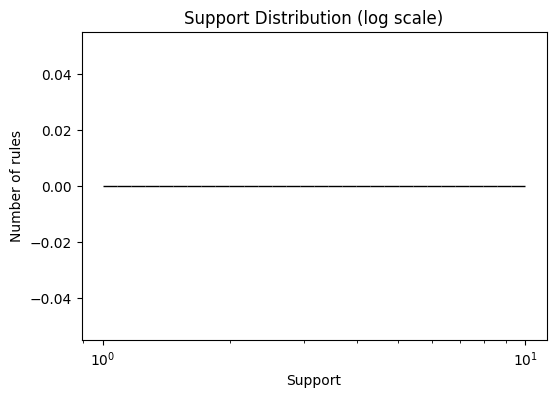

In [75]:
plt.figure(figsize=(6,4))
sns.histplot(
    rules_df_clean["support"],
    bins=30,
    log_scale=(True, False)  # log-scale trục X cho dễ nhìn
)
plt.title("Support Distribution (log scale)")
plt.xlabel("Support")
plt.ylabel("Number of rules")
plt.show()


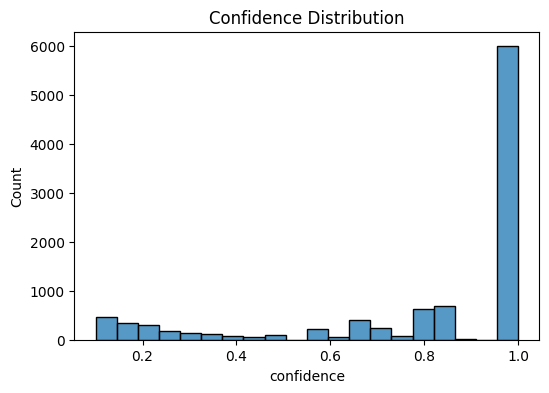

In [76]:
plt.figure(figsize=(6,4))
sns.histplot(rules_df_clean["confidence"], bins=20)
plt.title("Confidence Distribution")
plt.show()


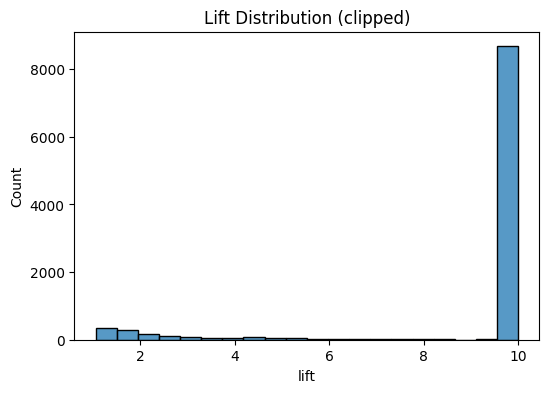

In [77]:
plt.figure(figsize=(6,4))
sns.histplot(rules_df_clean["lift"], bins=20)
plt.title("Lift Distribution (clipped)")
plt.show()


In [72]:
rules_df.sort_values("lift", ascending=False).head(10)


,context,antecedent_size,consequent,support,confidence,lift
10083,time_bucket=afternoon|is_weekend=1|lifecycle_s...,1,13176,0.0,0.2727,10.0
0,time_bucket=night|is_weekend=0|lifecycle_stage...,2,49195,0.0,1.0000,10.0
10063,time_bucket=afternoon|is_weekend=1|lifecycle_s...,1,8859,0.0,0.1429,10.0
10062,time_bucket=afternoon|is_weekend=1|lifecycle_s...,1,5479,0.0,0.1429,10.0
10061,time_bucket=afternoon|is_weekend=1|lifecycle_s...,1,19660,0.0,0.6667,10.0
10060,time_bucket=afternoon|is_weekend=1|lifecycle_s...,1,10957,0.0,0.6667,10.0
10059,time_bucket=afternoon|is_weekend=1|lifecycle_s...,1,45603,0.0,0.4000,10.0
10058,time_bucket=afternoon|is_weekend=1|lifecycle_s...,1,30776,0.0,0.6000,10.0
10057,time_bucket=afternoon|is_weekend=1|lifecycle_s...,1,18564,0.0,0.1667,10.0
10056,time_bucket=afternoon|is_weekend=1|lifecycle_s...,1,43504,0.0,0.1667,10.0
